<a href="https://colab.research.google.com/github/fuserkuba/OrderTaking/blob/master/training/TakeOrderTraining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

LOADING DATA

In [97]:
import pandas as pd
import numpy as np
import requests


filename = "https://raw.githubusercontent.com/fuserkuba/OrderTaking/master/training/orders.csv"

df = pd.read_csv(filename, na_values=[""], parse_dates=['created_at'], infer_datetime_format=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146987 entries, 0 to 146986
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   order_id           146987 non-null  int64         
 1   store_id           146987 non-null  int64         
 2   to_user_distance   146987 non-null  float64       
 3   to_user_elevation  146987 non-null  float64       
 4   total_earning      146987 non-null  int64         
 5   created_at         146987 non-null  datetime64[ns]
 6   taken              146987 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(4)
memory usage: 7.9 MB


# EXPLORATORY DATA ANALYSIS

In [73]:
display(df.head())

display(df.describe())

,order_id,store_id,to_user_distance,to_user_elevation,total_earning,created_at,taken
0,14364873,30000009,2.478101,-72.719360,4200,2017-09-07 20:02:17,0
1,14370123,30000058,0.451711,37.754761,4200,2017-09-07 20:13:16,0
2,14368534,900003684,2.026072,207.191162,4000,2017-09-07 20:07:23,0
3,14370258,900014452,2.671432,1.722656,4400,2017-09-07 20:15:19,1
4,14369923,900014085,0.965496,117.429199,3450,2017-09-07 20:12:14,1


,order_id,store_id,to_user_distance,to_user_elevation,total_earning,taken
count,1.469870e+05,1.469870e+05,146987.000000,146987.000000,146987.000000,146987.000000
mean,1.507718e+07,7.580708e+08,1.501015,26.899130,5358.641594,0.921218
std,4.750119e+05,3.214280e+08,0.845776,84.907724,1779.800955,0.269400
min,1.421073e+07,3.000000e+07,0.000000,-598.296875,0.000000,0.000000
25%,1.466969e+07,9.000045e+08,0.836511,-18.348755,4200.000000,1.000000
50%,1.509241e+07,9.000077e+08,1.390230,11.145264,5200.000000,1.000000
75%,1.547355e+07,9.000127e+08,2.029955,61.024353,6300.000000,1.000000
max,1.590252e+07,9.000173e+08,9.360177,1009.380005,108200.000000,1.000000


In [65]:
display(df.taken.value_counts().sort_index())
print("%0.2f percent of orders taken" % (df.taken.mean()*100))

0     11580
1    135407
Name: taken, dtype: int64

92.12 percent of orders taken


,order_id,store_id,to_user_distance,to_user_elevation,total_earning,created_at,taken
102163,14323700,900010714,1.388912,48.826538,0,2017-09-07T12:02:05Z,1


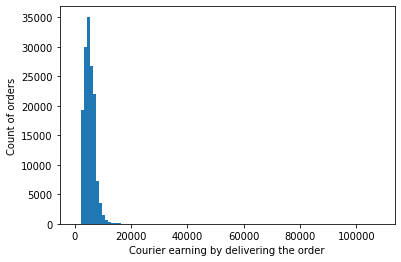

,order_id,store_id,to_user_distance,to_user_elevation,total_earning,created_at,taken
16847,14362872,900012381,0.0,0.0,5000,2017-09-07T19:48:10Z,0


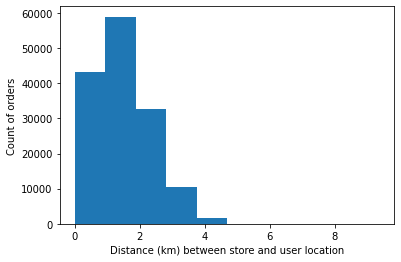

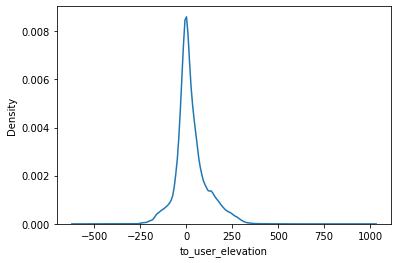

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# No earning
display(df[df.total_earning == 0].head())

plt.hist(df.total_earning, bins=100)
plt.xlabel('Courier earning by delivering the order')
plt.ylabel('Count of orders')
plt.show()


# No distance
display(df[df.to_user_distance == 0].head())
plt.hist(df.to_user_distance, bins=10)
plt.xlabel('Distance (km) between store and user location')
plt.ylabel('Count of orders')
plt.show()

#plt.hist(df.to_user_elevation, bins=100)
#plt.xlabel('Difference in meters between the store and user altitude')
#plt.ylabel('Count of orders')
#plt.show()
sns.kdeplot(df.to_user_elevation)



## FEATURE ENGINEERING

In [164]:
from collections import Counter

display(df.head())
display(df.describe())
print("Dataset: {}".format(df.shape))
print('Dataset classes %s' % Counter(df.taken))

df.total_earning.replace(0,np.nan, inplace=True)
df.to_user_distance.replace(0,np.nan, inplace=True)
df.dropna(inplace=True)

df['month']=df.created_at.dt.month
# Monday is 0 and Sunday is 6
df['weekday']=df.created_at.dt.weekday
df['day']=df.created_at.dt.day
df['hour']=df.created_at.dt.hour
df['working_time']=(df.created_at - pd.to_timedelta(8,unit='H')).dt.hour*60+df.created_at.dt.minute

min_qt=0.01
max_qt=0.99

# filter extreme values
df_ready = df[df.total_earning.gt(df.total_earning.quantile(min_qt))
        & df.total_earning.lt(df.total_earning.quantile(max_qt))
        & df.to_user_distance.gt(df.to_user_distance.quantile(min_qt))
        & df.to_user_distance.lt(df.to_user_distance.quantile(max_qt))
        & df.to_user_elevation.gt(df.to_user_elevation.quantile(min_qt))
        & df.to_user_elevation.lt(df.to_user_elevation.quantile(max_qt))]

print("\nFiltered dataset: {}".format(df_ready.shape))
print('Filtered dataset classes %s' % Counter(df_ready.taken))
display(df_ready.describe())

,order_id,store_id,to_user_distance,to_user_elevation,total_earning,created_at,taken,month,weekday,day,hour,working_time
0,14364873,30000009,2.478101,-72.719360,4200.0,2017-09-07 20:02:17,0,9,3,7,20,722
1,14370123,30000058,0.451711,37.754761,4200.0,2017-09-07 20:13:16,0,9,3,7,20,733
2,14368534,900003684,2.026072,207.191162,4000.0,2017-09-07 20:07:23,0,9,3,7,20,727
3,14370258,900014452,2.671432,1.722656,4400.0,2017-09-07 20:15:19,1,9,3,7,20,735
4,14369923,900014085,0.965496,117.429199,3450.0,2017-09-07 20:12:14,1,9,3,7,20,732


,order_id,store_id,to_user_distance,to_user_elevation,total_earning,taken,month,weekday,day,hour,working_time
count,1.469850e+05,1.469850e+05,146985.000000,146985.000000,146985.000000,146985.000000,146985.000000,146985.000000,146985.000000,146985.000000,146985.000000
mean,1.507719e+07,7.580689e+08,1.501026,26.899164,5358.680491,0.921223,9.124319,3.368629,16.007994,15.759261,516.452005
std,4.750074e+05,3.214297e+08,0.845773,84.908253,1779.757934,0.269391,0.329946,2.031409,8.709759,3.803294,227.689464
min,1.421073e+07,3.000000e+07,0.002456,-598.296875,200.000000,0.000000,9.000000,0.000000,1.000000,0.000000,0.000000
25%,1.466971e+07,9.000045e+08,0.836521,-18.348755,4200.000000,1.000000,9.000000,2.000000,9.000000,13.000000,320.000000
50%,1.509245e+07,9.000077e+08,1.390239,11.145264,5200.000000,1.000000,9.000000,4.000000,16.000000,16.000000,518.000000
75%,1.547356e+07,9.000127e+08,2.029967,61.026733,6300.000000,1.000000,9.000000,5.000000,24.000000,19.000000,695.000000
max,1.590252e+07,9.000173e+08,9.360177,1009.380005,108200.000000,1.000000,10.000000,6.000000,30.000000,23.000000,1439.000000


Dataset: (146985, 12)
Dataset classes Counter({1: 135406, 0: 11579})

Filtered dataset: (121100, 12)
Filtered dataset classes Counter({1: 112740, 0: 8360})


,order_id,store_id,to_user_distance,to_user_elevation,total_earning,taken,month,weekday,day,hour,working_time
count,1.211000e+05,1.211000e+05,121100.000000,121100.000000,121100.000000,121100.000000,121100.000000,121100.000000,121100.000000,121100.000000,121100.000000
mean,1.508509e+07,7.562192e+08,1.506939,28.350602,5570.334533,0.930966,9.125912,3.479397,16.090462,15.777787,519.114368
std,4.654947e+05,3.231051e+08,0.809854,79.106165,1441.106066,0.253513,0.331752,2.053898,8.652565,3.839756,229.571407
min,1.421073e+07,3.000000e+07,0.158367,-165.454834,3203.000000,0.000000,9.000000,0.000000,1.000000,0.000000,0.000000
25%,1.469873e+07,9.000044e+08,0.857849,-17.981873,4500.000000,1.000000,9.000000,2.000000,9.000000,13.000000,321.000000
50%,1.509862e+07,9.000077e+08,1.405103,13.009888,5200.000000,1.000000,9.000000,4.000000,17.000000,16.000000,524.000000
75%,1.545964e+07,9.000127e+08,2.041370,64.194855,6500.000000,1.000000,9.000000,5.000000,24.000000,19.000000,698.000000
max,1.590252e+07,9.000173e+08,3.773078,276.601074,10850.000000,1.000000,10.000000,6.000000,30.000000,23.000000,1439.000000


# TRAINING

In [166]:
features = ['to_user_distance','to_user_elevation','total_earning','weekday','day','hour','working_time']
target = ['taken']

X = df_ready[features].values
y = df_ready[target].values.ravel()

display(X[:5],X.shape)
display(y[:5],y.shape)

array([[ 2.47810068e+00, -7.27193604e+01,  4.20000000e+03,
         3.00000000e+00,  7.00000000e+00,  2.00000000e+01,
         7.22000000e+02],
       [ 4.51710600e-01,  3.77547607e+01,  4.20000000e+03,
         3.00000000e+00,  7.00000000e+00,  2.00000000e+01,
         7.33000000e+02],
       [ 2.02607186e+00,  2.07191162e+02,  4.00000000e+03,
         3.00000000e+00,  7.00000000e+00,  2.00000000e+01,
         7.27000000e+02],
       [ 2.67143172e+00,  1.72265625e+00,  4.40000000e+03,
         3.00000000e+00,  7.00000000e+00,  2.00000000e+01,
         7.35000000e+02],
       [ 9.65496042e-01,  1.17429199e+02,  3.45000000e+03,
         3.00000000e+00,  7.00000000e+00,  2.00000000e+01,
         7.32000000e+02]])

(121100, 7)

array([0, 0, 0, 1, 1], dtype=int64)

(121100,)

## PREPARE TRAIN AND TEST DATA

In [167]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=21, stratify=y)

print("Training set X: {}  y: {}".format(X_train.shape,y_train.shape))
print("Test set X: {}  y: {}".format(X_test.shape,y_test.shape))

print('Training dataset shape %s' % Counter(y_train))
print('Test dataset shape %s' % Counter(y_test))

Training set X: (84770, 7)  y: (84770,)
Test set X: (36330, 7)  y: (36330,)
Training dataset shape Counter({1: 78918, 0: 5852})
Test dataset shape Counter({1: 33822, 0: 2508})


In [168]:
from imblearn.combine import SMOTEENN # Combine over- and under-sampling using SMOTE and Edited Nearest Neighbours.
from imblearn.over_sampling import SMOTE # Class to perform over-sampling using SMOTE.
from imblearn.under_sampling import RandomUnderSampler # Under-sample the majority class(es) by randomly picking samples with or without replacement.
from imblearn.pipeline import Pipeline


#sme = SMOTEENN(random_state=42)
# define pipeline
over = SMOTE(sampling_strategy=0.2)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

# transform the dataset
X_res, y_res = pipeline.fit_resample(X_train, y_train)

print('Resampled dataset shape %s' % Counter(y_train))
print('Resampled dataset shape %s' % Counter(y_res))

X_train = X_res
y_train = y_res

Resampled dataset shape Counter({1: 78918, 0: 5852})
Resampled dataset shape Counter({1: 31566, 0: 15783})


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [169]:
from sklearn.preprocessing import StandardScaler
#
from sklearn.pipeline import Pipeline
#
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

#classifier = KNeighborsClassifier(n_neighbors=3)
classifier = RandomForestClassifier(criterion='gini',max_features='auto',n_jobs=-1)
#classifier = xgb.XGBClassifier(objective='binary:logistic', n_estimators=10, seed=123)

steps = [('scaler', StandardScaler()),
         ('clf', classifier)]

pipeline = Pipeline(steps)

# parameters = {'clf__n_neighbors': (3,5,10)}
parameters = {
'clf__max_depth': [80, 100],
'clf__max_features': [2, 4],
'clf__min_samples_leaf': [3, 5],
'clf__min_samples_split': [8, 10],
'clf__n_estimators': [300, 400],
'clf__class_weight': ['balanced','balanced_subsample']
}

display(parameters)


{'clf__class_weight': ['balanced', 'balanced_subsample'],
 'clf__max_depth': [80, 100],
 'clf__max_features': [2, 4],
 'clf__min_samples_leaf': [3, 5],
 'clf__min_samples_split': [8, 10],
 'clf__n_estimators': [300, 400]}

## CROSS VALIDATION

In [170]:
from sklearn.model_selection import GridSearchCV
from pprint import pprint
from time import time

grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, scoring='roc_auc')

print("Performing grid search...")
print("pipeline:", [name for name, _ in pipeline.steps])
t0 = time()
grid_search.fit(X_train, y_train)
print("Done in %0.3fs" % (time() - t0))
print()
print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
  print("\t%s: %r" % (param_name, best_parameters[param_name]))

model=grid_search.best_estimator_

print("\nBEST MODEL :")
display(model)

print("BEST SCORE : {}".format(grid_search.best_score_))

Performing grid search...
pipeline: ['scaler', 'clf']
Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 15.9min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 78.9min
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed: 139.0min finished


Done in 8369.833s

Best score: 0.907
Best parameters set:
	clf__class_weight: 'balanced_subsample'
	clf__max_depth: 100
	clf__max_features: 2
	clf__min_samples_leaf: 3
	clf__min_samples_split: 8
	clf__n_estimators: 400

BEST MODEL :


Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('clf',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight='balanced_subsample',
                                        criterion='gini', max_depth=100,
                                        max_features=2, max_leaf_nodes=None,
                                        max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=3, min_samples_split=8,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=400, n_jobs=-1,
                                        oob_score=False, random_state=None,
                                        verbose=0, warm_start=False))

BEST SCORE : 0.9073640193153997


## TEST MODEL

confusion matrix:
[[  674  1834]
 [ 2018 31804]]
              precision    recall  f1-score   support

           0       0.25      0.27      0.26      2508
           1       0.95      0.94      0.94     33822

    accuracy                           0.89     36330
   macro avg       0.60      0.60      0.60     36330
weighted avg       0.90      0.89      0.90     36330

ROC_AUC: 0.60
Accuracy: 0.89


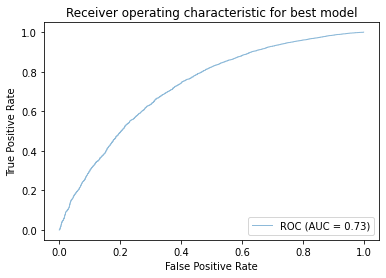

In [171]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_roc_curve

y_pred = model.predict(X_test)

print("confusion matrix:")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC_AUC: %0.2f" % roc_auc_score(y_test, y_pred))
print("Accuracy: %0.2f" % accuracy_score(y_test, y_pred))

fig, ax = plt.subplots()
viz = plot_roc_curve(model, X_test, y_test,name='ROC',alpha=0.5, lw=1, ax=ax)
ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic for best model")
ax.legend(loc="lower right")
plt.show()

# SAVE MODEL

In [172]:
import joblib

filename='model.joblib'

joblib.dump(model, filename)

['model.joblib']